<a href="https://colab.research.google.com/github/Justabhi96/face_recognition_system/blob/master/face_recognition_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install face_recognition

In [0]:
import cv2
import face_recognition as fr
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

In [0]:
class face_recognition_system:
  """
  This class has function for recognizing people in the photos. It also contains functions for adding, removing and updating people.
  
  Attributes:
    pickle_file_name(string): name of the pickle file in which face encodings of people will be stored or is stored
  """
  
  def __init__(self, pickle_file_name = "face_encodings.pickle"):
    """
    Contructor for the class.
    
    Parameters:
      pickle_file_name(string): name of the pickle file in which face encodings for people will be stored or is stored.
 
    """
    self.pickle_file_name = pickle_file_name
    if os.path.exists(pickle_file_name):
      if os.path.getsize(pickle_file_name) > 0:
        with open(pickle_file_name, "rb") as face_encodings_pickle:
          self._known_emp_data = pickle.load(face_encodings_pickle)
          self._known_emp_encodings = [i[0] for i in self._known_emp_data]
          self._known_emp_names = [i[1].lower() for i in self._known_emp_data]
      else:
        self._known_emp_data = []
        self._known_emp_encodings, self._known_emp_names = [],[]
    else:
      self._known_emp_data = []
      self._known_emp_encodings, self._known_emp_names = [],[]
      with open(pickle_file_name, "wb") as face_encodings_pickle:
        pickle.dump([], face_encodings_pickle)
  
  def _save_in_pickle(self):
    """
    Saves the known people face encodings in a pickle.
    """
    
    with open(self.pickle_file_name, "wb") as known_face_pickle:
      pickle.dump(self._known_emp_data, known_face_pickle)
    self.__init__(self.pickle_file_name)
  
  def get_emp_names(self):
    """
    returns name of employees in record
    """
    return self._known_emp_names
    
  def check_emp_existence(self, emp_name):
    """
    Checks if an employee already exist in records.
    
    Parametes:
      emp_name(string): name of the employee to be checked existence for.
      
    Returns:
      boolean: True if exists else False
    """
    
    emp_name = emp_name.lower()
    if emp_name in self._known_emp_names:
      return True
    return False
  
  def add_emp(self, image_path, emp_name):
    """
    Adds a new employee in the records.
    
    Parameters:
      image_path(string): path to the image of employee to be added.
      emp_name(string): name of the employee to be added.
      
    Returns:
      None
    """
    
    emp_name = emp_name.lower()
    if self.check_emp_existence(emp_name):
      print("Name already exists in records. Please use 'update_emp' function instead.")
      return
    image_enc = fr.face_encodings(fr.load_image_file(image_path))[0]
    self._known_emp_data.append([image_enc, emp_name])
    self._save_in_pickle()
    print("Employee added")
  
  def remove_emp(self, emp_name):
    """
    Removes an existing employee from the records.
    
    Parameters:
      emp_name(string): name of employee to be removed.
      
    Returns:
      None
    """
    
    emp_name = emp_name.lower()
    if self.check_emp_existence(emp_name):
      index = self._known_emp_names.index(emp_name)
      self._known_emp_data.pop(index)
      self._save_in_pickle()
      print("Employee Removed")
    else:
      print("Employee does not exists in records")
      
  def update_emp(self, image_path, emp_name):
    """
    Updates an existing employee face encoding in the known face encodings
    
    Parameters:
      image_path(string): path to the image of employee to be updated.
      emp_name(string): name of the employee to be updated.
      
    Returns:
      None
    """
    
    emp_name = emp_name.lower()
    if self.check_emp_existence(emp_name):
      image_enc = fr.face_encodings(fr.load_image_file(image_path))[0]
      index = self._known_emp_names.index(emp_name)
      self._known_emp_data[index][0] = image_enc
      self._save_in_pickle()
      print("Employee Updated")
    else:
      print("Employee does not exists in records")
    
  def recognize(self, image_path):
    """
    Matches the given person(s) with the known people in the records and returns the employee name(s).
    
    Prints the image passed in the console with person name.
    
    Parameters:
      image_path(string): path to the image which has poeple to be recognized.
      
    Returns:
      None
    """
    
    image = fr.load_image_file(image_path)
    face_locations = fr.face_locations(image, model = "cnn")
    images_encoding = fr.face_encodings(image, face_locations)
    
    for i in range(len(images_encoding)):
      top, right, bottom, left = face_locations[i]
      compare_results = fr.compare_faces(self._known_emp_encodings, images_encoding[i], 0.5)
      if True in compare_results:
        index = compare_results.index(True)
        recognized_emp_name = self._known_emp_names[index].capitalize()
      else:
        recognized_emp_name = "Unknown"
      cv2.rectangle(image, (left, top), (right, bottom), color = (0, 0, 255), thickness = 5)
      cv2.putText(image, recognized_emp_name, (left, bottom+30), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), thickness = 2)
    cv2_imshow(image)
    
  def recognize_in_video(self, video_path):
    """
    Recognizes poeple in the video.
    
    Parameters:
      video_path(string): path of video file.
      
    Returns:
      None
    """
    
    video = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*"XVID")
    out = cv2.VideoWriter('output.mp4', fourcc, 20.0, (640, 480))
    process_frame = True
    while True:
      is_feed, frame = video.read()
      if is_feed:
        emp_names = []
        if process_frame:
          small_frame = cv2.resize(frame, (0,0), fx = 0.25, fy = 0.25)
          rgb_small_frame = small_frame[:,:,::-1]

          face_locations = fr.face_locations(rgb_small_frame, model = "cnn")
          images_encoding = fr.face_encodings(rgb_small_frame, face_locations)

          for i in range(len(images_encoding)):
            top, right, bottom, left = face_locations[i]
            compare_results = fr.compare_faces(self._known_emp_encodings, images_encoding[i], 0.5)
            if True in compare_results:
              index = compare_results.index(True)
              emp_name = self._known_emp_names[index]
            else:
              emp_name = "Unknown"
            emp_names.append(emp_name)

        process_frame = not process_frame

        for (top, right, bottom, left), name in zip(face_locations, emp_names):
          top, right, bottom, left = [i*4 for i in (top, right, bottom, left)]

          # Draw a box around the face
          cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)

          # Draw a label with a name below the face
          cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
          font = cv2.FONT_HERSHEY_DUPLEX
          cv2.putText(frame, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)

        out.write(frame)
      else:
        out.release()
        break

In [0]:
recognition_system = face_recognition_system()

In [5]:
recognition_system.check_emp_existence("paul walker")

False

In [6]:
recognition_system.add_emp("paul.jpg", "paul walker")

Employee added


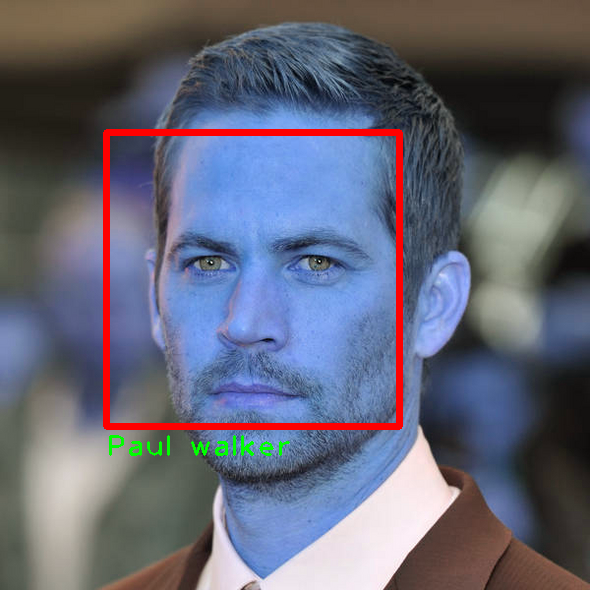

In [7]:
recognition_system.recognize("paul1.jpg")

In [8]:
recognition_system.update_emp("paul1.jpg", "paul walker")

Employee Updated


In [9]:
recognition_system.remove_emp("paul walker")

Employee Removed


In [10]:
recognition_system.check_emp_existence("paul walker")

False